In [1]:
import pandas as pd
from pyarrow import csv
import pyarrow.parquet as pq

# load the parquet file
df = pq.read_table('data/traffic_data.parquet').to_pandas()

# load latlon data
latlon = pd.read_csv('data/latlon.csv')

pop = pd.read_csv('data/population.csv')
# change types to int
pop['year'] = pop['year'].astype(int)
pop['population'] = pop['population'].astype(int)
pop = pop[::-1]
# reverse just the index
pop = pop.reset_index(drop=True)
pop['growth_rate'] = 1
for i in range(len(pop)):
    if i > 0:
        pop['growth_rate'][i] = pop['population'][i] / pop['population'][i-1]

# function that takes in a tuple and returns a list
def tuple_to_list(tup):
    return [tup[0], tup[1]]

# function that takes in a tuple stored as string and returns a tuple
def string_to_tuple(tup_str):
    # remove the parentheses and split by comma
    tup_str = tup_str[1:-1]
    return tuple(map(float, tup_str.split(',')))

latlon["latlon"] = latlon["latlon"].apply(lambda x: string_to_tuple(x))
latlon["latlon"] = latlon["latlon"].apply(lambda x: tuple_to_list(x))

df = df.reset_index()

C:\Users\bence\AppData\Local\Temp\ipykernel_29520\1590911301.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pop['growth_rate'][i] = pop['population'][i] / pop['population'][i-1]


In [2]:
# take only date column and columns with T in name
stationAvailability = df[["datetime"] + [col for col in df.columns if " T" in col]]

for station in stationAvailability.columns[1:]:
    # convert to true or false based on value being -1 or else
    stationAvailability.loc[:,station] = stationAvailability.loc[:,station].apply(lambda x: 0 if x == -1 else 1)

stationAvailabilityCopy = stationAvailability.copy()

for station in stationAvailability.columns[1:]:
    stationAvailability.loc[:,station] = stationAvailability.loc[:,station]-stationAvailability.loc[:,station].shift(1)
    stationAvailability.loc[0,station] = 0 if df.loc[0,station] == -1 else 1

# discard all rows where all values are 0
stationAvailability = stationAvailability[abs(stationAvailability.iloc[:, 1:]).sum(axis=1) > 0]

<Figure size 1400x1000 with 0 Axes>

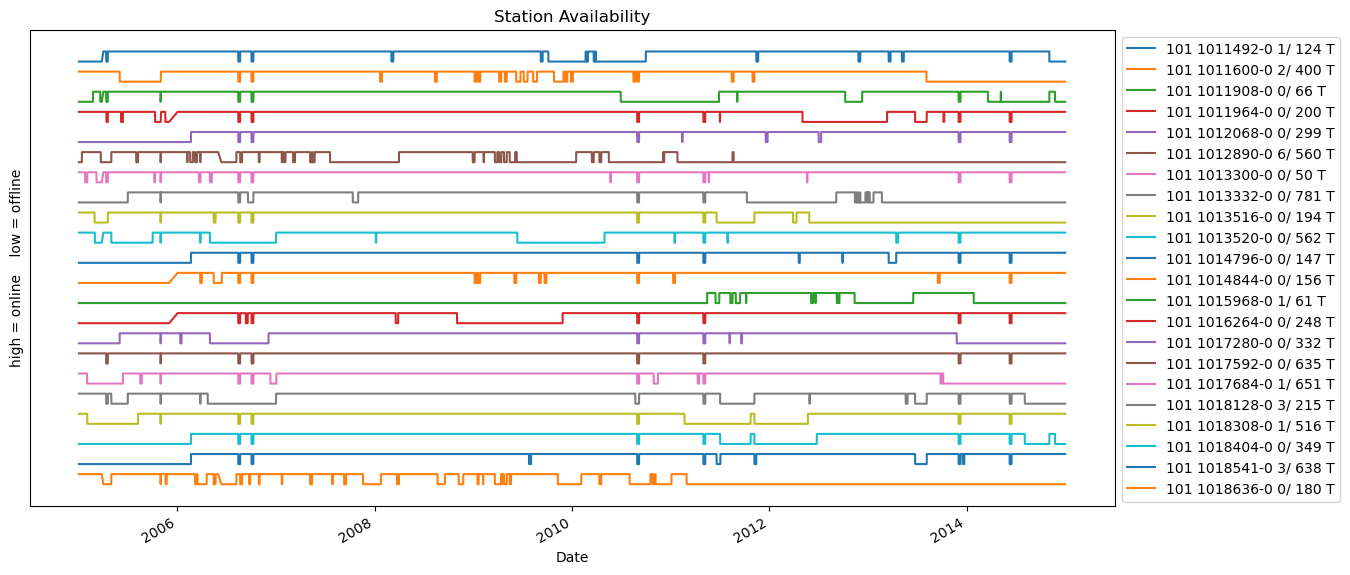

In [3]:
# plot of station availability (online/offline status) over time
import matplotlib.pyplot as plt

data = stationAvailabilityCopy.copy()
i = 0
for col in data.columns[1:]:
    # convert to true or false based on value being -1 or else
    data[col] = data[col] + i
    i -= 2 # offset by 2 for each station

plt.figure(figsize=(14, 10))
data.plot(x="datetime", figsize=(14, 7), title="Station Availability")
plt.xlabel("Date")
plt.ylabel("high = online    low = offline")
# hide y ticks
plt.yticks([])
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))


In [4]:
#print(stationAvailability[stationAvailability.iloc[:,1]!=0.0].iloc[:,0].tolist())

def pairer(l):
    return [(l[i], l[i + 1]) for i in range(0, len(l), 2)]

print(stationAvailability[stationAvailability.iloc[:,1]== 1.0].iloc[:,0].tolist())
print(stationAvailability[stationAvailability.iloc[:,1]==-1.0].iloc[:,0].tolist())
print(pd.Timestamp("2019-01-01 01:00:00") > pd.Timestamp("2019-01-01 00:00:00"))

def onoffpairs(on,off):
    startsAsOn = on[0] == pd.Timestamp("2005-01-01 00:00:00")
    endsAsOn = on[-1] > off[-1]

    if not(startsAsOn):
        off = [pd.Timestamp("2005-01-01 00:00:00")] + off
    if endsAsOn:
        off = off + [pd.Timestamp("2014-12-31 00:00:00")]
    else:
        on = on + [pd.Timestamp("2014-12-31 00:00:00")]
    
    online = []
    offline = []

    #print(startsAsOn, endsAsOn)

    if startsAsOn and endsAsOn:
        for i in range(len(on)-1):
            online  += [[on[i], off[i]]]
            offline += [[off[i], on[i+1]]]
        online += [[on[-1], off[-1]]]

    elif not(startsAsOn) and not(endsAsOn):
        for i in range(len(off)-1):
            offline += [[off[i], on[i]]]
            online  += [[on[i], off[i+1]]]
        offline += [[off[-1], on[-1]]]

    elif startsAsOn and not(endsAsOn):
        for i in range(len(on)-1):
            online  += [[on[i], off[i]]]
            offline += [[off[i], on[i+1]]]
    
    elif not(startsAsOn) and endsAsOn:
        for i in range(len(off)-1):
            offline += [[off[i], on[i]]]
            online  += [[on[i], off[i+1]]]
    
    return online, offline


[Timestamp('2005-04-01 00:00:00'), Timestamp('2005-04-18 00:00:00'), Timestamp('2006-08-21 00:00:00'), Timestamp('2006-10-09 00:00:00'), Timestamp('2008-03-10 00:00:00'), Timestamp('2009-09-14 00:00:00'), Timestamp('2010-02-20 00:00:00'), Timestamp('2010-03-01 00:00:00'), Timestamp('2010-03-28 00:00:00'), Timestamp('2010-10-01 00:00:00'), Timestamp('2011-11-21 00:00:00'), Timestamp('2012-12-03 00:00:00'), Timestamp('2013-03-25 00:00:00'), Timestamp('2013-05-13 00:00:00'), Timestamp('2014-06-16 00:00:00')]
[Timestamp('2005-04-12 00:00:00'), Timestamp('2006-08-14 00:00:00'), Timestamp('2006-10-02 00:00:00'), Timestamp('2008-03-03 00:00:00'), Timestamp('2009-09-07 00:00:00'), Timestamp('2009-10-05 00:00:00'), Timestamp('2010-02-22 00:00:00'), Timestamp('2010-03-22 00:00:00'), Timestamp('2010-03-30 00:00:00'), Timestamp('2011-11-14 00:00:00'), Timestamp('2012-11-26 00:00:00'), Timestamp('2013-03-18 00:00:00'), Timestamp('2013-05-06 00:00:00'), Timestamp('2014-06-09 00:00:00'), Timestamp('2

In [5]:
#[x.strftime("%Y-%m-%dT%H:%M:%S") for x in onoffpairs(stationAvailability[stationAvailability.iloc[:,1]== 1.0].iloc[:,0].tolist(), stationAvailability[stationAvailability.iloc[:,1]==-1.0].iloc[:,0].tolist())[0][0]]

#latlon[latlon["Vej-Id"] == stationAvailability.columns[1]]["latlon"].tolist()[0][::-1]

#stationAvailability[stationAvailability.columns[1]]

#stationAvailability.columns[len(stationAvailability.columns[1:])]

#stationAvailability.iloc[1,0].strftime("%Y-%m-%dT%H:%M:%S")

#stations = set(latlon["latlon"].apply(lambda x: tuple(x)))
#stations = list(stations)
#stations = [tuple_to_list(tup) for tup in stations]

In [6]:
# plot that shows station availability (online/offline status) over time

import folium.plugins
import folium

m = folium.Map(location=[55.65184, 12.55388], zoom_start=12)

points = []

for i in range(len(stationAvailability.columns[1:])-1):
    pointpairs = onoffpairs(stationAvailability[stationAvailability.iloc[:,i+1]== 1.0].iloc[:,0].tolist(), stationAvailability[stationAvailability.iloc[:,i+1]==-1.0].iloc[:,0].tolist())
    points += [
        {
            "order" : on[0] + pd.Timedelta(seconds=i),
            "coordinates" :  latlon[latlon["Vej-Id"] == stationAvailability.columns[i+1]]["latlon"].tolist()[0][::-1],
            "times": [time.strftime("%Y-%m-%dT%H:%M:%S") for time in on],
            "color": "green",
        }
        for on in pointpairs[0]
    ]
    points += [
        {
            "order" : off[0] + pd.Timedelta(seconds=i),
            "coordinates" :  latlon[latlon["Vej-Id"] == stationAvailability.columns[i+1]]["latlon"].tolist()[0][::-1],
            "times": [time.strftime("%Y-%m-%dT%H:%M:%S") for time in off],
            "color": "red",
        }
        for off in pointpairs[1]
    ]

def order_json_elements(json_list):
    return sorted(json_list, key=lambda x: x["order"])

points = order_json_elements(points)

features = [
    {
        "type": "Feature",
        "geometry": {
            "type": "Point",
            "coordinates": point["coordinates"],
        },
        "properties": {
            "times": point["times"],
            "icon": "circle",
            "iconstyle": {
                "fillColor": point["color"],
                "fillOpacity": 1.0,
                "stroke": True,
                "radius": 5,
                "color": point["color"],
            },
        },
    }
    for point in points
]

folium.plugins.TimestampedGeoJson(
    {
        "type": "FeatureCollection",
        "features": features,
    },
    period="P1D",  # Skip days for each frame
    max_speed=31,
    add_last_point=True,
).add_to(m)
print(len(features))
m



552


In [7]:
import math
import numpy as np

def approx_distance(coord1, coord2):
    lat1, lon1 = coord1
    lat2, lon2 = coord2

    lat_factor = 111320  # Meters per degree latitude
    lon_factor = 111320 * math.cos(math.radians(lat1))  # Adjust for latitude

    dx = (lon2 - lon1) * lon_factor
    dy = (lat2 - lat1) * lat_factor

    return math.sqrt(dx**2 + dy**2)


# I needed extra coordinates with an offset detailing the direction of the road for each station
# for this I went through google maps and selected a station and a point near the station for each road
# since I didn't exactly click on the station I had to match my coordinates to the station coordinates
directions = pd.read_csv('data/directions.csv')

# formatting the csv a bit better
directions['latlon1'] = directions.apply(lambda row: [row['lat1'], row['lon1']], axis=1)
directions['latlon2'] = directions.apply(lambda row: [row['lat2'], row['lon2']], axis=1)

# drop the lat and lon columns
directions = directions.drop(columns=['lat1', 'lon1', 'lat2', 'lon2'])

# get column with a coordinate that I treat as a basis vector for road direction
# now I can draw lines on the road from each station by multiplying delta and adding it to the station coordinates
directions['delta'] = directions['latlon2'].apply(lambda x: np.array(x)) - directions['latlon1'].apply(lambda x: np.array(x))
directions['distance'] = directions.apply(lambda row: approx_distance(row['latlon1'], row['latlon2']), axis=1)
directions['delta'] = directions.apply(lambda row: [row['delta'][0]/row['distance'], row['delta'][1]/row['distance']], axis=1)


# this function takes in a dataframe with coordinates and matches them to the nearest coordinates in another dataframe
def simple_match_nearest(df_ref, df_target, coord_col_ref='coord', coord_col_target='coord'):

    ref_coords = np.vstack(df_ref[coord_col_ref].values)
    target_coords = np.vstack(df_target[coord_col_target].values)

    matches = []
    for ref_point in ref_coords:
        distances = np.linalg.norm(target_coords - ref_point, axis=1)
        idx = np.argmin(distances)
        match_row = df_target.iloc[idx].copy()
        match_row['matched_distance'] = distances[idx]
        matches.append(match_row)

    matched_df = df_ref.reset_index(drop=True).copy()
    matched_data = pd.DataFrame(matches).reset_index(drop=True)
    result = pd.concat([matched_df, matched_data.add_prefix("matched_")], axis=1)

    return result

matching0 = simple_match_nearest(latlon, directions, 'latlon', 'latlon1')

In [8]:
# plot that tests whether delta coordinates are correctly scaled despite lat lon distortion

def circle_coordinates(center, radius, num_points, distort=False):
    lat, lon = center
    coordinates = []
    for i in range(num_points+1):
        angle = 2 * math.pi * i / num_points
        dx = radius * math.cos(angle)
        dy = radius * math.sin(angle)
        if distort:
            coordinates.append([lat + dy / 111320, lon + dx / (111320)])
        else:
            coordinates.append([lat + dy / 111320, lon + dx / (111320 * math.cos(math.radians(lat)))])
    return coordinates

# create a circle in copenhagen
circle1 = circle_coordinates([55.65184, 12.55388], 1000, 30)
circle2 = circle_coordinates([55.65184, 12.55388], 1000, 30, distort=True)


m = folium.Map(location=[55.65184, 12.55388], zoom_start=12)

folium.PolyLine(circle1, color="blue", weight=2.5, opacity=1).add_to(m)
folium.PolyLine(circle2, color="red", weight=2.5, opacity=1).add_to(m)

# load points from the deltas
for point in directions['delta'].tolist():
    point = [point[0]*1000, point[1]*1000]
    point = [point[0]+55.65184, point[1]+12.55388]
    folium.Marker(location=point, popup="Marker").add_to(m)

for point in directions['delta'].tolist():
    point = [point[0]*-1000, point[1]*-1000]
    point = [point[0]+55.65184, point[1]+12.55388]
    folium.Marker(location=point, popup="Marker").add_to(m)

m

In [9]:
# 1 day traffic animation with colour scale uniform across all stations

from folium.plugins import TimestampedGeoJson

lilD = matching0[matching0["Vej-Id"].str.endswith(" T")].copy()

def listVadd(l1, l2,mult=1):
    return [l1[0]+l2[0]*mult, l1[1]+l2[1]*mult]

m = folium.Map(location=[55.68574, 12.571037], zoom_start=12, tiles="Cartodb Positron")
w = 5

lilData = df[df["datetime"] >= pd.Timestamp("2014-05-02 00:00:00")].copy()
lilData = lilData[lilData["datetime"] <= pd.Timestamp("2014-05-03 00:00:00")].copy()

# drop all columns by some condition
lilData = lilData.drop(columns=[col for col in lilData.columns[1:] if "101" not in col])
maximum = np.array(lilData[lilData.columns[~lilData.columns.str.contains(" T")]].max().tolist()[1:]).max()
lilData.iloc[:,1:] = (lilData.iloc[:,1:]/maximum)*600

features = []
lines = []


import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def count2color(count):
    if count < 0:
        return "#000000"  # Black for negative values
    norm = mcolors.Normalize(vmin=0, vmax=600)
    cmap = plt.colormaps.get_cmap("jet")
    rgba = cmap(norm(count))
    return mcolors.to_hex(rgba)

for index, row in lilData.iterrows():
    for col in lilData.columns[1:]:
        count = row[col]
        point = matching0[matching0['Vej-Id'] == col]['latlon'].tolist()[0][::-1]
        delta = matching0[matching0['Vej-Id'] == col]['matched_delta'].tolist()[0][::-1]
        times = [time.strftime("%Y-%m-%dT%H:%M:%S") for time in [row['datetime'], row['datetime']+pd.Timedelta(seconds=1)]]
        if col.endswith("-"): # into the city
            lines.append({
                "order": row['datetime'],
                "coordinates" : [point, listVadd(point,delta,600)],
                "color": "white",
                "times": times,
            })
            lines.append({
                "order": row['datetime']+pd.Timedelta(seconds=1),
                "coordinates" : [point, listVadd(point,delta,count)],
                "color": count2color(count),
                "times": times,
            })
        elif col.endswith("+"): # out of the city
            lines.append({
                "order": row['datetime'],
                "coordinates" : [point, listVadd(point,delta,-600)],
                "color": "white",
                "times": times,
            })
            lines.append({
                "order": row['datetime']+pd.Timedelta(seconds=1),
                "coordinates" : [point, listVadd(point,delta,-count)],
                "color": count2color(count),
                "times": times,
            })
        elif col.endswith(" T"): # Total is used as just the place to add the white dot in the middle
            if count >= 0:
                lines.append({
                "order": row['datetime']+pd.Timedelta(seconds=2),
                "coordinates" : [point, point],
                "color": "white",
                "times": times,
            })
            else:
                lines.append({
                "order": row['datetime']+pd.Timedelta(seconds=2),
                "coordinates" : [point, point],
                "color": "red",
                "times": times,
            })

def order_json_elements(json_list):
    return sorted(json_list, key=lambda x: x["order"])

lines = order_json_elements(lines)

features = [{
                "type": "Feature",
                "geometry": {
                    "type": "LineString",
                    "coordinates": line["coordinates"],
                },
                "properties": {
                    "times": line["times"],
                    "style": {"color": line["color"], "weight": w}
                }
            } for line in lines ]

TimestampedGeoJson(
    {
        "type": "FeatureCollection",
        "features": features
    },
    period="PT1H",
    add_last_point=False,
    transition_time=200,
    loop=True,
    auto_play=True,
    loop_button=True,
    time_slider_drag_update=True,
).add_to(m)
print(len(features))
m

2750


In [10]:
#np.array(lilData[lilData.columns[~lilData.columns.str.contains(" T")]].max().tolist()[1:])*100
# here I was working out how to met max traffic value in both direction then dividing both by the same value
# I didn't use max value of Total because that will be higher than both directions leading to the line
# not using the full scale
""" 

print(lilData[lilData.columns[~lilData.columns.str.contains("101 1015968-0 1/ 61")]].max().tolist()[1:])

print(lilData[lilData.columns[~lilData.columns.str.contains("101 1015968-0 1/ 61")]].max().tolist()[1::3])
print(lilData[lilData.columns[~lilData.columns.str.contains("101 1015968-0 1/ 61")]].max().tolist()[2::3])
print(lilData[lilData.columns[~lilData.columns.str.contains("101 1015968-0 1/ 61")]].max().tolist()[3::3])

print(np.array([lilData[lilData.columns[~lilData.columns.str.contains("101 1015968-0 1/ 61")]].max().tolist()[1::3],
      lilData[lilData.columns[~lilData.columns.str.contains("101 1015968-0 1/ 61")]].max().tolist()[2::3]]).max(axis=0))

lilData[lilData.columns[~lilData.columns.str.contains("101 1015968-0 1/ 61")]].iloc[:,2::3]

"""

' \n\nprint(lilData[lilData.columns[~lilData.columns.str.contains("101 1015968-0 1/ 61")]].max().tolist()[1:])\n\nprint(lilData[lilData.columns[~lilData.columns.str.contains("101 1015968-0 1/ 61")]].max().tolist()[1::3])\nprint(lilData[lilData.columns[~lilData.columns.str.contains("101 1015968-0 1/ 61")]].max().tolist()[2::3])\nprint(lilData[lilData.columns[~lilData.columns.str.contains("101 1015968-0 1/ 61")]].max().tolist()[3::3])\n\nprint(np.array([lilData[lilData.columns[~lilData.columns.str.contains("101 1015968-0 1/ 61")]].max().tolist()[1::3],\n      lilData[lilData.columns[~lilData.columns.str.contains("101 1015968-0 1/ 61")]].max().tolist()[2::3]]).max(axis=0))\n\nlilData[lilData.columns[~lilData.columns.str.contains("101 1015968-0 1/ 61")]].iloc[:,2::3]\n\n'

In [11]:
# 1 day traffic animation with colour scale unique to each stations own range

from folium.plugins import TimestampedGeoJson

lilD = matching0[matching0["Vej-Id"].str.endswith(" T")].copy()

def listVadd(l1, l2,mult=1):
    return [l1[0]+l2[0]*mult, l1[1]+l2[1]*mult]

m = folium.Map(location=[55.68574, 12.571037], zoom_start=12, tiles="Cartodb Positron")
w = 5

lilData = df[df["datetime"] >= pd.Timestamp("2014-05-02 00:00:00")].copy()
lilData = lilData[lilData["datetime"] <= pd.Timestamp("2014-05-03 00:00:00")].copy()

# drop all columns by some condition
lilData = lilData.drop(columns=[col for col in lilData.columns[1:] if "101" not in col])
lilData = lilData[lilData.columns[~lilData.columns.str.contains("101 1015968-0 1/ 61")]]

# get maximum value in either direction, use later to scale both directions
maximums = np.array([lilData.max().tolist()[1::3],
                     lilData.max().tolist()[2::3]]).max(axis=0)
lilData.iloc[:,1::3] = lilData.iloc[:,1::3].apply(lambda x: (x/abs(x.max())*600), axis=0)
lilData.iloc[:,2::3] = lilData.iloc[:,2::3].apply(lambda x: (x/abs(x.max())*600), axis=0)

features = []
lines = []


import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def count2color(count):
    if count < 0:
        return "#FFFFFF"  # White for negative values (nan won't show up like this) 
    norm = mcolors.Normalize(vmin=0, vmax=600)
    cmap = plt.colormaps.get_cmap("jet")
    rgba = cmap(norm(count))
    return mcolors.to_hex(rgba)

for index, row in lilData.iterrows():
    for col in lilData.columns[1:]:
        count = row[col]
        point = matching0[matching0['Vej-Id'] == col]['latlon'].tolist()[0][::-1]
        delta = matching0[matching0['Vej-Id'] == col]['matched_delta'].tolist()[0][::-1]
        times = [time.strftime("%Y-%m-%dT%H:%M:%S") for time in [row['datetime'], row['datetime']+pd.Timedelta(seconds=1)]]
        if col.endswith("-"): # into city
            lines.append({
                "order": row['datetime'],
                "coordinates" : [point, listVadd(point,delta,600)],
                "color": "white",
                "times": times,
            })
            lines.append({
                "order": row['datetime']+pd.Timedelta(seconds=1),
                "coordinates" : [point, listVadd(point,delta,count)],
                "color": count2color(count),
                "times": times,
            })
        elif col.endswith("+"): # out of city
            lines.append({
                "order": row['datetime'],
                "coordinates" : [point, listVadd(point,delta,-600)],
                "color": "white",
                "times": times,
            })
            lines.append({
                "order": row['datetime']+pd.Timedelta(seconds=1),
                "coordinates" : [point, listVadd(point,delta,-count)],
                "color": count2color(count),
                "times": times,
            })
        elif col.endswith(" T"): # Total is used as just the place to add the white dot in the middle
            if count >= 0:
                lines.append({
                "order": row['datetime']+pd.Timedelta(seconds=2),
                "coordinates" : [point, point],
                "color": "white",
                "times": times,
            })
            else:
                lines.append({
                "order": row['datetime']+pd.Timedelta(seconds=2),
                "coordinates" : [point, point],
                "color": "red",
                "times": times,
            })

# If it's not ordered, the animation will not work properly, check other prototypes of this below for explanation
def order_json_elements(json_list):
    return sorted(json_list, key=lambda x: x["order"])

lines = order_json_elements(lines)

features = [{
                "type": "Feature",
                "geometry": {
                    "type": "LineString",
                    "coordinates": line["coordinates"],
                },
                "properties": {
                    "times": line["times"],
                    "style": {"color": line["color"], "weight": w}
                }
            } for line in lines ]

TimestampedGeoJson(
    {
        "type": "FeatureCollection",
        "features": features
    },
    period="PT1H",
    add_last_point=False,
    transition_time=200,
    loop=True,
    auto_play=True,
    loop_button=True,
    time_slider_drag_update=True,
).add_to(m)
print(len(features))
m

2625


In [12]:
# Select year range you want to investigate
df_sub = df[(df["datetime"] >= pd.Timestamp("2005-01-01 00:00:00")) & (df["datetime"] <= pd.Timestamp("2015-01-01 00:00:00"))].copy()

# add hour column, drop all columns not compatible with groupby() and irrelevant ones
df_sub['hour'] = df_sub['datetime'].dt.hour
df_sub.drop(columns=['datetime','temperature_2m (°C)','relative_humidity_2m (%)','rain (mm)','snowfall (cm)', 'wind_speed_10m (km/h)',
                    'weather_code (wmo code)','apparent_temperature (°C)','cloud_cover (%)','DayOfWeek','isHoliday','isWeekend','holidayName',
                    'holidayType'], inplace=True)
# replace -1 with NaN
# this together with mean will account for the fact that some stations are not available at all times
df_sub = df_sub.replace(-1, pd.NA)
dayCounts = df_sub.groupby(['isWeekday', 'hour']).mean().reset_index()
# drop any stations that didn't have data for selected date range
dayCounts = dayCounts.dropna(axis=1, how='any')
dayCounts

isWeekday  hour  101 1011492-0 1/ 124 +  101 1011492-0 1/ 124 -  \
0       False     0              381.937215              272.474886   
1       False     1              258.438356              199.364155   
2       False     2              206.242009              157.747717   
3       False     3              173.636986              138.237443   
4       False     4              159.719178               140.90411   
5       False     5              168.119863              164.567352   
6       False     6              193.253425              197.063927   
7       False     7               239.68379              250.853881   
8       False     8              333.455479               391.98516   
9       False     9              512.332192              675.910959   
10      False    10              684.365297              872.098174   
11      False    11              830.828767             1011.812785   
12      False    12              938.549087             1083.469178   
13      False    13              976.658676             1092.691781   
14      False    14             1003.160959             1052.021689   
15      False    15              995.555936              957.496575   
16      False    16              984.439498               892.61758   
17      False    17              918.070776              863.116438   
18      False    18               731.46347              737.770548   
19      False    19              575.229452              594.716895   
20      False    20              515.694064              522.765982   
21      False    21              493.320776              449.815068   
22      False    22               441.80137              406.783105   
23      False    23              387.426941              312.496575   
24       True     0              179.902249              125.972923   
25       True     1              108.409362               86.536026   
26       True     2               84.764571               72.595686   
27       True     3               84.499312               91.519963   
28       True     4              118.422212               165.55576   
29       True     5               236.13263               487.35475   
30       True     6              567.836163             1072.083525   
31       True     7             1019.757228             1468.026618   
32       True     8              989.014227             1441.133089   
33       True     9              868.924277             1218.890776   
34       True    10              916.753098             1084.836622   
35       True    11             1027.986232             1071.121615   
36       True    12             1146.591556             1088.513079   
37       True    13             1249.244149             1069.161083   
38       True    14             1510.301056             1116.298302   
39       True    15             1608.438733             1285.949059   
40       True    16             1535.776962              1367.72648   
41       True    17             1290.217072             1192.873795   
42       True    18              979.346489              940.924277   
43       True    19              754.201927              663.278568   
44       True    20              660.775126              518.905461   
45       True    21              601.167049              442.773291   
46       True    22                529.0771               391.67967   
47       True    23              397.874713              260.560808   

    101 1011492-0 1/ 124 T  101 1011600-0 2/ 400 +  101 1011600-0 2/ 400 -  \
0                 654.4121              113.925316              129.270886   
1               457.802511               78.892405               89.917722   
2               363.989726               57.551899               66.825316   
3               311.874429               49.297468               52.689873   
4               300.623288               61.487342               56.211392   
5               332.687215               70.134177      

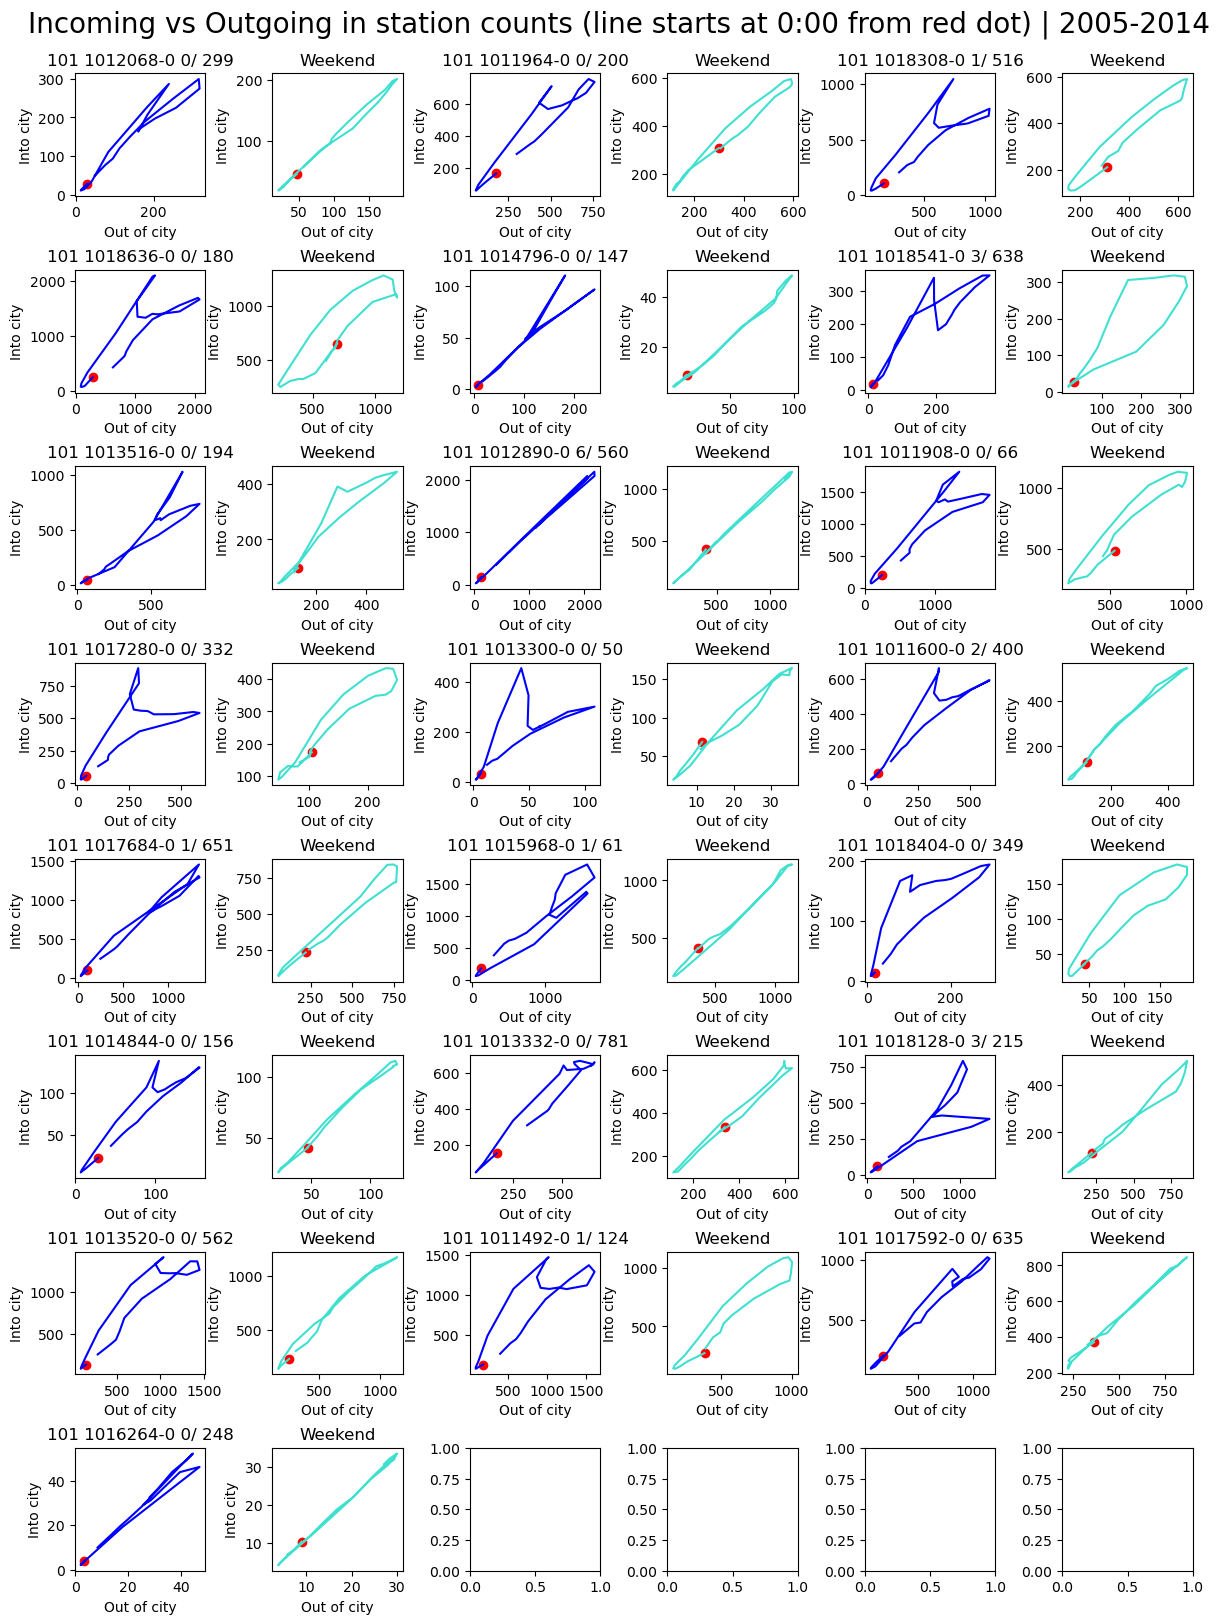

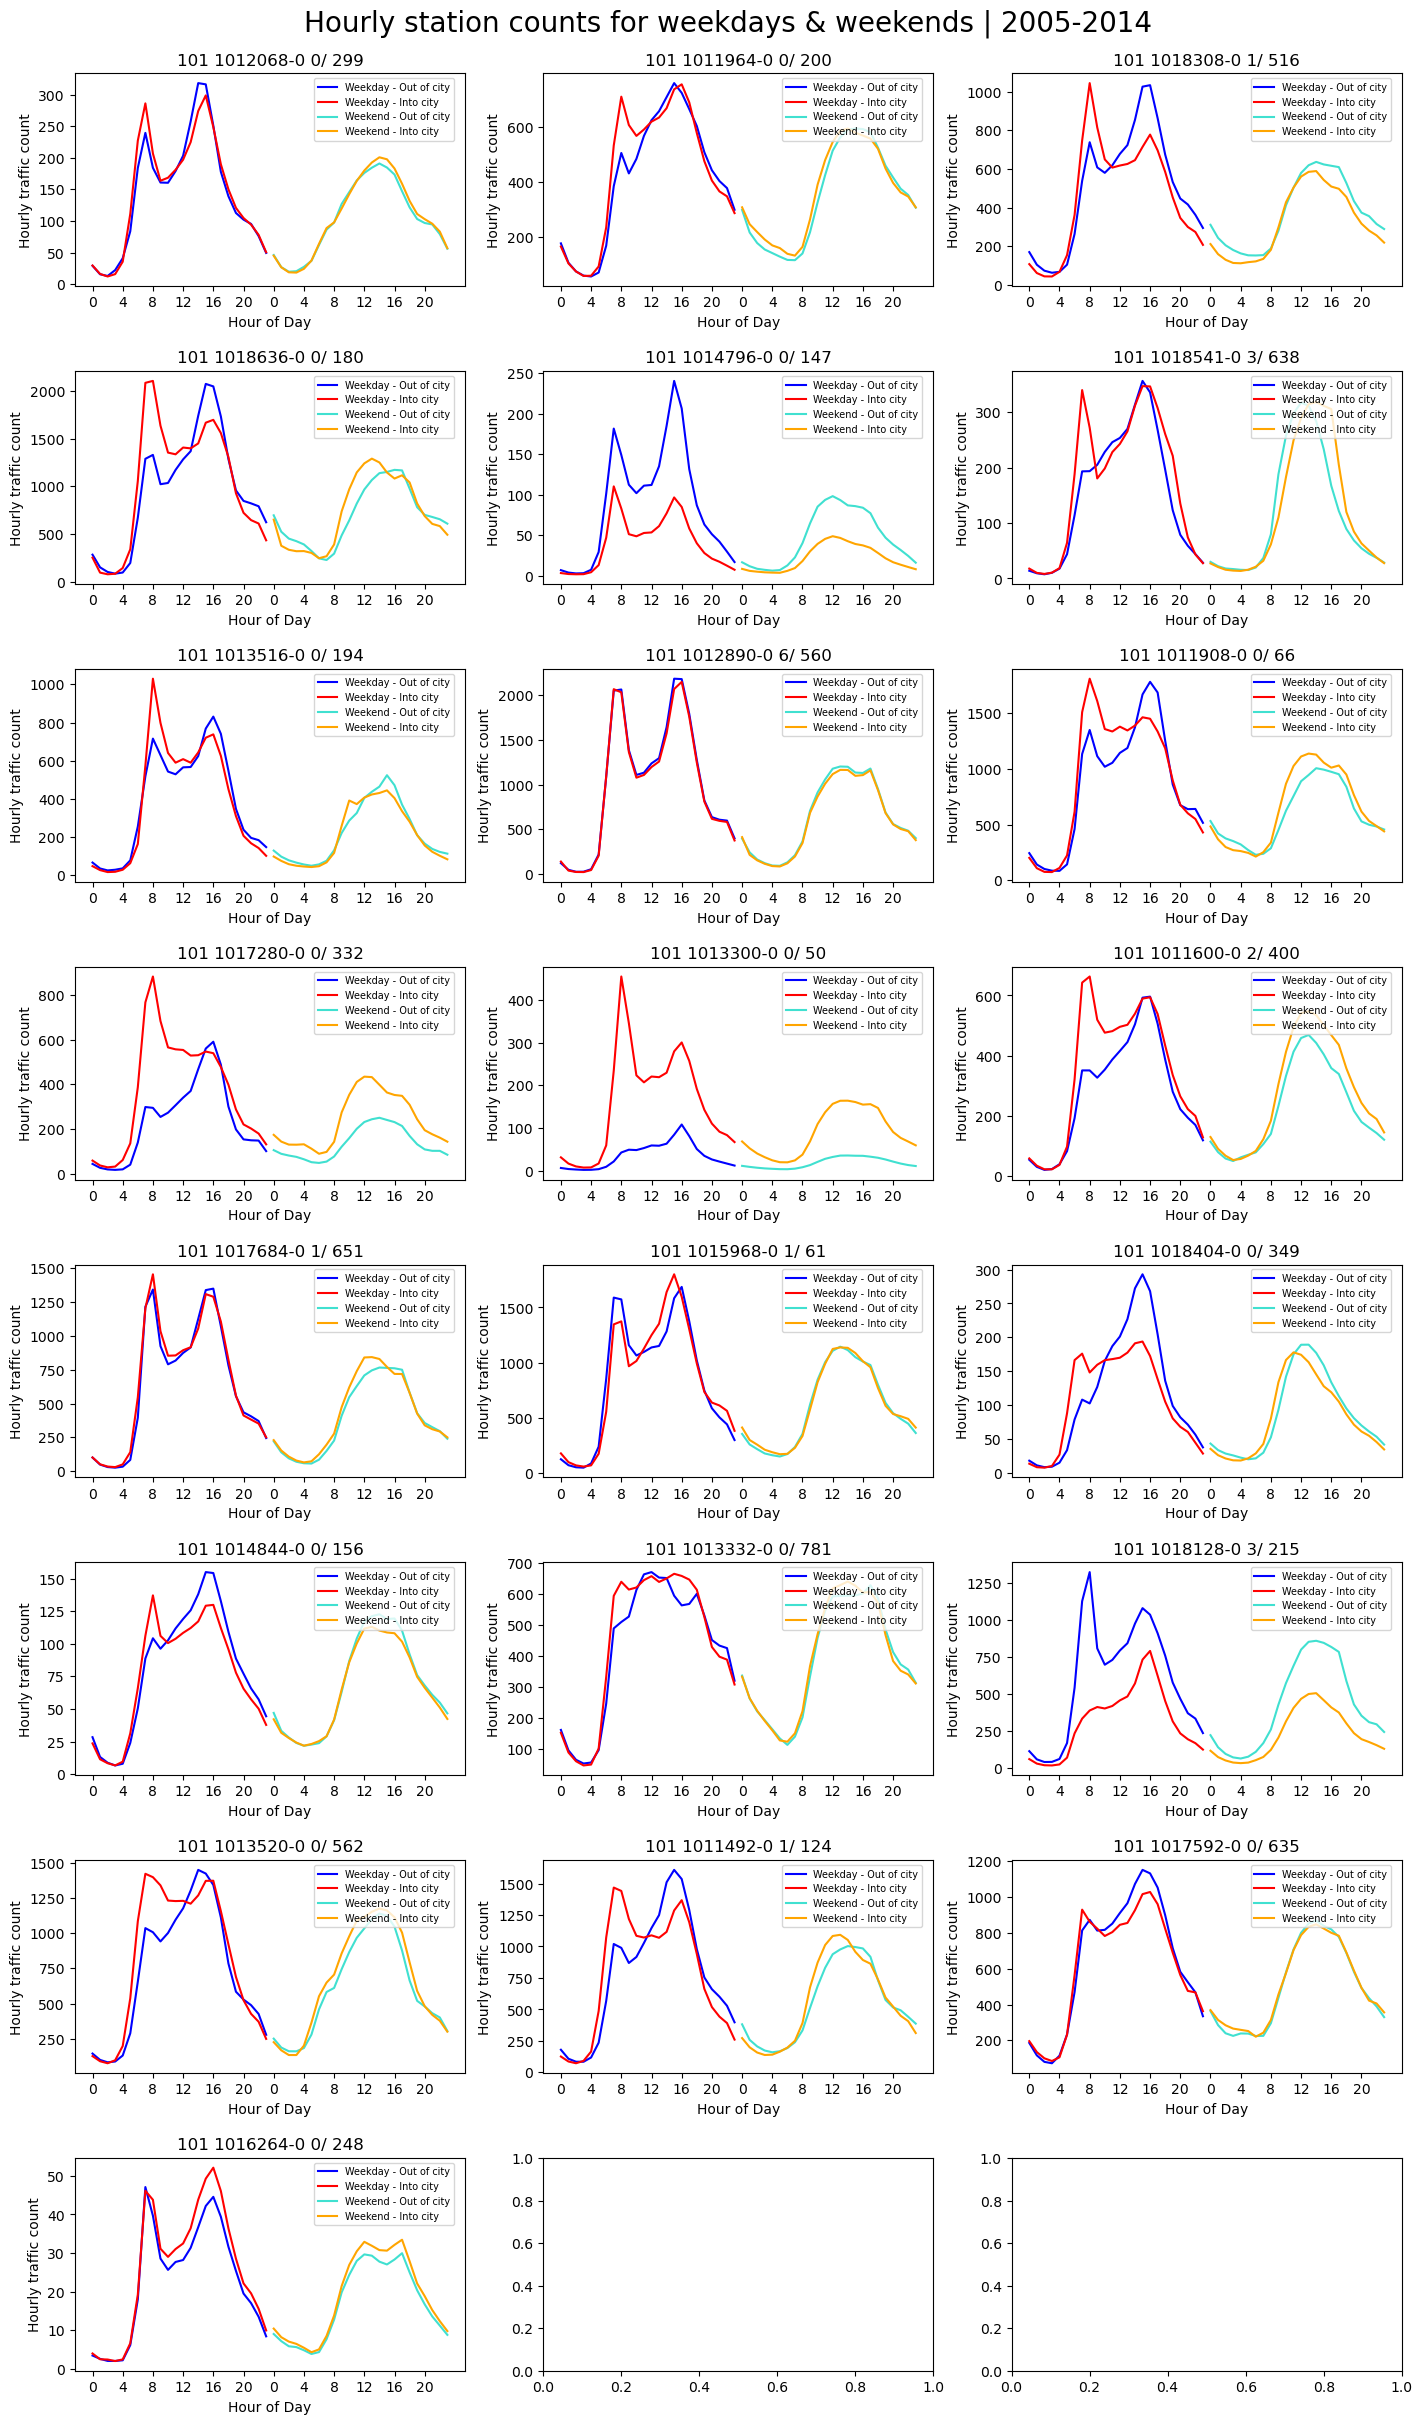

In [13]:
import matplotlib.pyplot as plt

# get list of road ids without the +-T
stations = list(set([s1[0:-1] if s1[-1] == " " else s1 for s1 in [s[0:-2] for s in dayCounts.columns.tolist()]][2:]))
# print(len(stations))

# make plot of 6 columns and as many rows as needed
# figure of weekday data then figure of weekend data then repeat with next station
fig, axs = plt.subplots(-(-len(stations)*2//6), 6, figsize=(6*2,-(-len(stations)*2//6)*2))
fig.suptitle('Incoming vs Outgoing in station counts (line starts at 0:00 from red dot) | 2005-2014', fontsize=20, y=1) # y 
plt.tight_layout()
axs = axs.flatten() 

i=0
for station in stations:
        subset = dayCounts[['isWeekday','hour',station+" +",station+" -"]].copy()

        # plot weekday data
        axs[i].scatter(subset[subset['isWeekday']].iloc[0,2],
                       subset[subset['isWeekday']].iloc[0,3],color="red")
        axs[i].plot(subset[subset['isWeekday']].iloc[:,2],
                    subset[subset['isWeekday']].iloc[:,3],color="blue")
        axs[i].set_title(station)
        axs[i].set_xlabel("Out of city")
        axs[i].set_ylabel("Into city")
        
        # plot weekend data
        axs[i+1].scatter(subset[~subset['isWeekday']].iloc[0,2],
                         subset[~subset['isWeekday']].iloc[0,3],color="red")
        axs[i+1].plot(subset[~subset['isWeekday']].iloc[:,2],
                      subset[~subset['isWeekday']].iloc[:,3],color="turquoise")
        axs[i+1].set_title("Weekend")
        axs[i+1].set_xlabel("Out of city")
        axs[i+1].set_ylabel("Into city")
        
        i += 2
plt.subplots_adjust(hspace=0.6)
plt.show()

# columns of 3 with as many rows as needed
# plot weekly data with weekday and weekend separated but still in the same figure
fig, axs = plt.subplots(-(-len(stations)//3), 3, figsize=(1*14,-(-len(stations)//3)*3))
fig.suptitle('Hourly station counts for weekdays & weekends | 2005-2014', fontsize=20, y=1)
plt.tight_layout()
axs = axs.flatten() 

i=0
for station in stations:
        subset = dayCounts[['isWeekday','hour',station+" +",station+" -"]].copy()

        # plot weekday data
        axs[i].plot(subset[subset['isWeekday']].iloc[:,1],
                    subset[subset['isWeekday']].iloc[:,2],color="blue",label="Weekday - Out of city")
        axs[i].plot(subset[subset['isWeekday']].iloc[:,1],
                    subset[subset['isWeekday']].iloc[:,3],color="red",label="Weekday - Into city")
        
        # plot weekend data
        axs[i].plot(subset[~subset['isWeekday']].iloc[:,1]+24,
                      subset[~subset['isWeekday']].iloc[:,2],color="turquoise",label="Weekend - Out of city")
        axs[i].plot(subset[~subset['isWeekday']].iloc[:,1]+24,
                      subset[~subset['isWeekday']].iloc[:,3],color="orange",label="Weekend - Into city")
        axs[i].set_title(station)
        
        axs[i].set_xlabel("Hour of Day")
        axs[i].set_ylabel("Hourly traffic count")
        axs[i].set_xticks(range(0, 2*24, 4))
        axs[i].set_xticklabels([str(i) for i in range(0, 24, 4)]*2)
        axs[i].legend(loc='upper left', bbox_to_anchor=(0.6, 1),prop={'size': 7})
        
        i += 1
plt.subplots_adjust(hspace=0.4, wspace=0.2)
plt.show()

Just experiments from here on #################################################################

In [14]:
# this was prototype without the time series implemented

lilD = matching0[matching0["Vej-Id"].str.endswith(" T")].copy()

def listVadd(l1, l2,mult=1):
    return [l1[0]+l2[0]*mult, l1[1]+l2[1]*mult]

m = folium.Map(location=[55.65184, 12.55388], zoom_start=12, tiles="Cartodb Positron")

w = 5
for index, row in lilD.iterrows():
    point = row['latlon']
    delta = row['matched_delta']

    #folium.PolyLine([point, listVadd(point,delta,600)], color="white", weight=w, opacity=1).add_to(m)
    #folium.PolyLine([point, listVadd(point,delta,-600)], color="white", weight=w, opacity=1).add_to(m)
    # seems like some of the white lines get drawn over the coloured ones of other stations, could be solved by looping over
    # the stations twice for background white and coloured data, folium is so amazing (gazez outside window with longing for the sun)

    folium.PolyLine([listVadd(point,delta,0), listVadd(point,delta,300)], color="red", weight=w, opacity=1).add_to(m)
    folium.PolyLine([listVadd(point,delta,0), listVadd(point,delta,-300)], color="blue", weight=w, opacity=1).add_to(m)
    # later this could be colourmapped also, something like jet could be cool

    folium.CircleMarker(location=point,radius=2,color="white", fillColor="green", fillOpacity=1.0).add_to(m)
    # This is drawn because the thickness of one line will cover up the start of the other and lead to it looking longer
    # than it should be :)))))))) I will drag folium across the finish line by it's hair if I have to I swear to god I will


m

In [15]:
# prototype on force clearing lines by drawing them in white

import folium
from folium.plugins import TimestampedGeoJson
import datetime

# Map center
center = [55.6761, 12.5683]
base_lat = center[0]
spacing = 0.005
start_time = datetime.datetime.utcnow()

features = []
line_color = "red"
erase_color = "white"  # Or use the map background color


for i in range(3):
    lat = base_lat + i * spacing
    coords = [
        [center[1] - 0.01, lat],
        [center[1] + 0.01, lat]
    ]

    appear_t0 = (start_time + datetime.timedelta(seconds=i * 2)).isoformat() + "Z"
    appear_t1 = (start_time + datetime.timedelta(seconds=i * 2 + 1)).isoformat() + "Z"

    erase_t0 = (start_time + datetime.timedelta(seconds=i * 2 + 1)).isoformat() + "Z"
    erase_t1 = (start_time + datetime.timedelta(seconds=i * 2 + 2)).isoformat() + "Z"

    # Red line (original)
    features.append({
        "type": "Feature",
        "geometry": {
            "type": "LineString",
            "coordinates": coords
        },
        "properties": {
            "times": [appear_t0, appear_t1],
            "style": {"color": line_color, "weight": 4}
        }
    })

    # White line (eraser)
    features.append({
        "type": "Feature",
        "geometry": {
            "type": "LineString",
            "coordinates": coords
        },
        "properties": {
            "times": [erase_t0, erase_t1],
            "style": {"color": erase_color, "weight": 5}
        }
    })

# Build the map
m = folium.Map(location=[55.65184, 12.55388], zoom_start=12)

TimestampedGeoJson(
    {
        "type": "FeatureCollection",
        "features": features
    },
    period="PT1S",
    add_last_point=False,
    transition_time=200,
    loop=True,
    auto_play=True,
    loop_button=True,
    time_slider_drag_update=True,
).add_to(m)

#m.save("folium_animated_lines_erase.html")
m
